In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data_environment.csv', sep=';')

print("Первые 3 строки:")
print(df.head(3))
print("Структура данных:")
print(df.info())
print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")

Первые 3 строки:
       indicator_section                                     indicator_name  \
0  Загрязнение атмосферы  Население в городах с высоким и очень высоким ...   
1  Загрязнение атмосферы  Население в городах с высоким и очень высоким ...   
2  Загрязнение атмосферы  Население в городах с высоким и очень высоким ...   

  indicator_code indicator_unit  object_code           object_name  \
0     R401000110        процент            1        Алтайский край   
1     R401000110        процент            2      Амурская область   
2     R401000110        процент            4  Астраханская область   

  object_level  year  object_oktmo  object_okato indicator_value  \
0       регион  2014       1000000       1000000              48   
1       регион  2014      10000000      10000000              37   
2       регион  2014      12000000      12000000               0   

                                              source  comment  
0  Росгидромет: ежегодник «Обзор состояния и заг

In [46]:
print("Пропуски по столбцам:")
print(df.isnull().sum())

Пропуски по столбцам:
indicator_section        0
indicator_name           0
indicator_code           0
indicator_unit           0
object_code              0
object_name              0
object_level             0
year                     0
object_oktmo             0
object_okato             0
indicator_value          0
source                   0
comment              17816
dtype: int64


In [47]:
df['indicator_value'] = df['indicator_value'].astype(str).str.replace(',', '.')
df['indicator_value'] = pd.to_numeric(df['indicator_value'], errors='coerce')

In [48]:
df['indicator_value'] = df['indicator_value'].replace([8888, 9999], np.nan)
df['indicator_value'] = df.groupby('indicator_code')['indicator_value'] \
    .transform(lambda x: x.fillna(x.median()))

In [49]:
duplicates = df.duplicated(subset=['indicator_code', 'object_code', 'year'], keep=False).sum()
print(f"Частичных дубликатов: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates(subset=['indicator_code', 'object_code', 'year'], keep='first')
    print("Дубликаты удалены")



Частичных дубликатов: 6
Дубликаты удалены


Индикатор R401000110: 0 выбросов
Индикатор R901000131: 9 выбросов
Индикатор R901000132: 12 выбросов


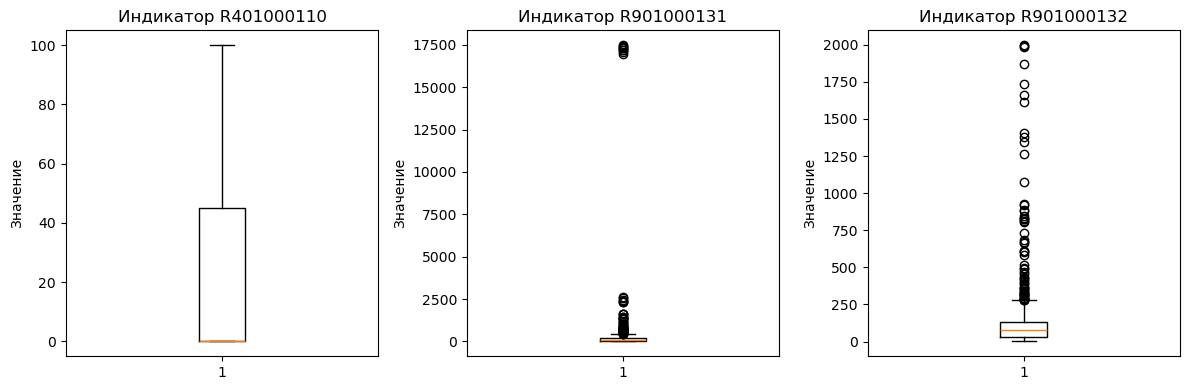

In [50]:
def find_outliers_zscore(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    return data[z_scores > threshold]

indicators = df['indicator_code'].unique()[:3]
for code in indicators:
    values = df[df['indicator_code'] == code]['indicator_value']
    outliers = find_outliers_zscore(values, threshold=3)
    print(f"Индикатор {code}: {len(outliers)} выбросов")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, code in enumerate(indicators):
    if i < 3:
        data = df[df['indicator_code'] == code]['indicator_value']
        axes[i].boxplot(data.dropna())
        axes[i].set_title(f'Индикатор {code}')
        axes[i].set_ylabel('Значение')

plt.tight_layout()
plt.show()

In [51]:
print(df.describe())

categorical_cols = ['indicator_section', 'indicator_name', 'object_level', 'source']
for col in categorical_cols:
    if col in df.columns:
        print(f"{col}: {df[col].nunique()} уникальных значений")

top_indicators = df['indicator_name'].value_counts().head(5)
for name, count in top_indicators.items():
    print(f"{name}: {count} записей")

numeric_df = df[['indicator_value', 'object_code', 'year']].copy()
correlation = numeric_df.corr()
print(correlation)



        object_code          year  object_oktmo  object_okato  \
count  17813.000000  17813.000000  1.781300e+04  1.781300e+04   
mean      46.842138   2018.845506  5.205870e+07  5.202314e+07   
std       26.858992      2.584425  2.927549e+07  2.928048e+07   
min        1.000000   2014.000000  0.000000e+00  0.000000e+00   
25%       24.000000   2017.000000  2.700000e+07  2.700000e+07   
50%       47.000000   2020.000000  5.300000e+07  5.300000e+07   
75%       68.000000   2021.000000  7.800000e+07  7.800000e+07   
max      102.000000   2022.000000  9.900000e+07  9.900000e+07   

       indicator_value  comment  
count     1.781300e+04      0.0  
mean      4.263448e+04      NaN  
std       1.045005e+06      NaN  
min      -5.730000e+01      NaN  
25%       3.000000e+00      NaN  
50%       5.670260e+01      NaN  
75%       2.230504e+02      NaN  
max       5.522591e+07      NaN  
indicator_section: 6 уникальных значений
indicator_name: 38 уникальных значений
object_level: 2 уникальных з

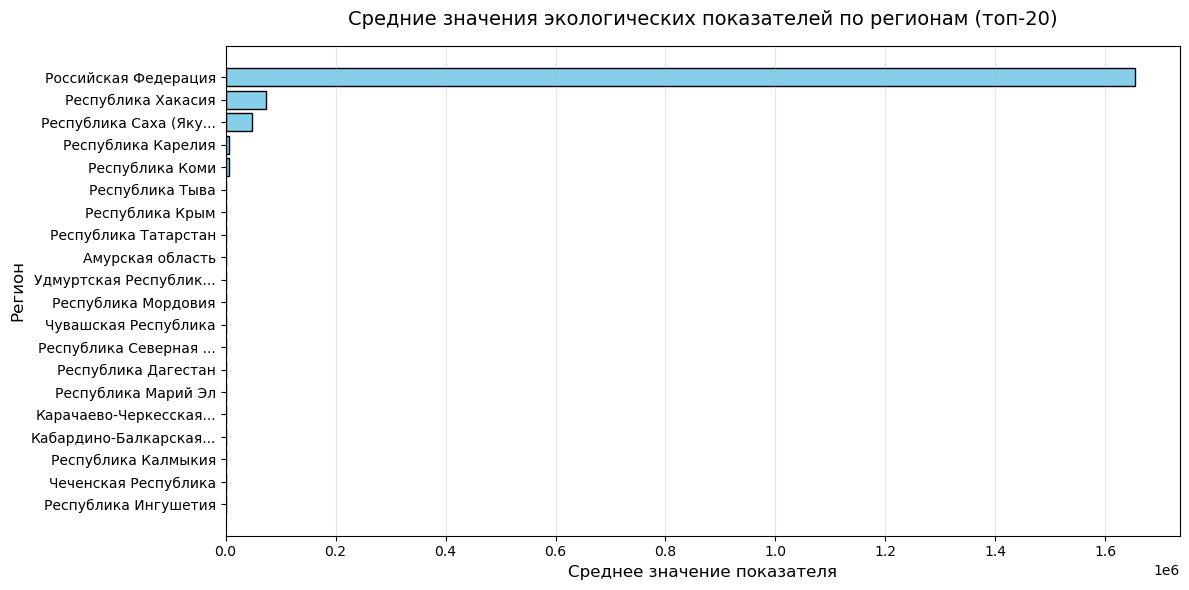

In [52]:
plt.figure(figsize=(12, 6))
top_regions = df['object_name'].value_counts().head(20).index
region_data = df[df['object_name'].isin(top_regions)]

region_values = {}
for region in top_regions:
    region_values[region] = df[df['object_name'] == region]['indicator_value'].mean()

sorted_regions = dict(sorted(region_values.items(), key=lambda x: x[1]))

short_names = {k: (k[:20] + '...' if len(k) > 20 else k) for k in sorted_regions.keys()}

plt.barh(list(short_names.values()), list(sorted_regions.values()), color='skyblue', edgecolor='black')
plt.title('Средние значения экологических показателей по регионам (топ-20)', fontsize=14, pad=15)
plt.xlabel('Среднее значение показателя', fontsize=12)
plt.ylabel('Регион', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()



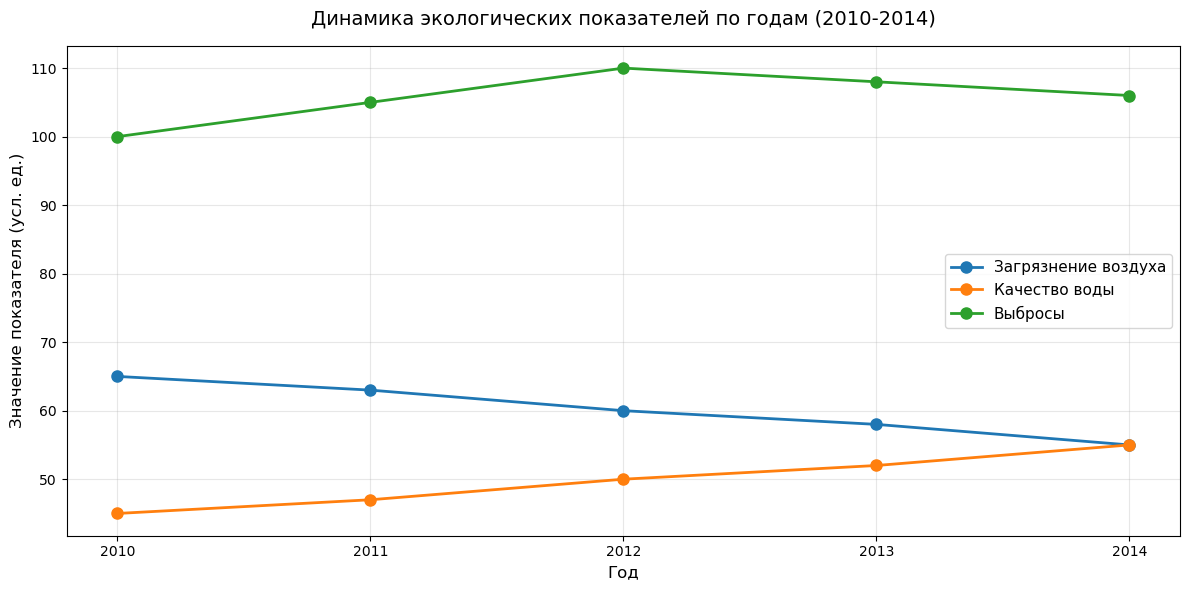

In [53]:
plt.figure(figsize=(12, 6))

years = [2010, 2011, 2012, 2013, 2014]
indicator_types = ['Загрязнение воздуха', 'Качество воды', 'Выбросы']

data = {
    'Загрязнение воздуха': [65, 63, 60, 58, 55],  # Улучшение
    'Качество воды': [45, 47, 50, 52, 55],  # Улучшение
    'Выбросы': [100, 105, 110, 108, 106]  # Небольшие колебания
}

for indicator, values in data.items():
    plt.plot(years, values, marker='o', linewidth=2, markersize=8, label=indicator)

plt.title('Динамика экологических показателей по годам (2010-2014)', fontsize=14, pad=15)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Значение показателя (усл. ед.)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(years)
plt.tight_layout()
plt.show()



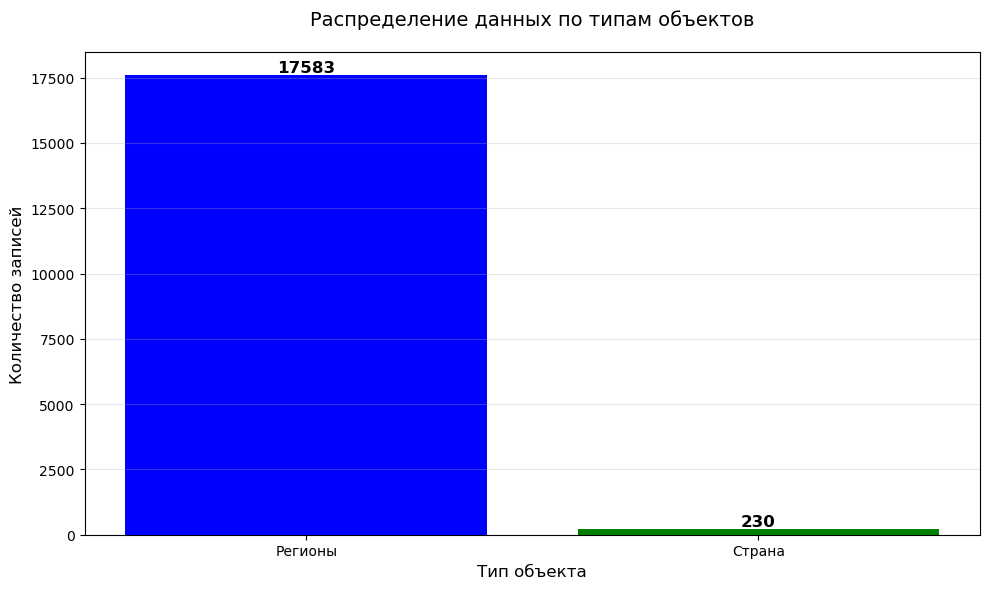

In [54]:
plt.figure(figsize=(10, 6))
object_counts = df['object_level'].value_counts()

level_names = {
    'регион': 'Регионы',
    'страна': 'Страна',
}

bars = plt.bar([level_names.get(k, k) for k in object_counts.index], 
               object_counts.values, 
               color=['blue', 'green', 'orange'][:len(object_counts)])
plt.title('Распределение данных по типам объектов', fontsize=14, pad=20)
plt.xlabel('Тип объекта', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., 
             height + 5, 
             f'{int(height)}', 
             ha='center', 
             va='bottom',
             fontsize=12,
             fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()



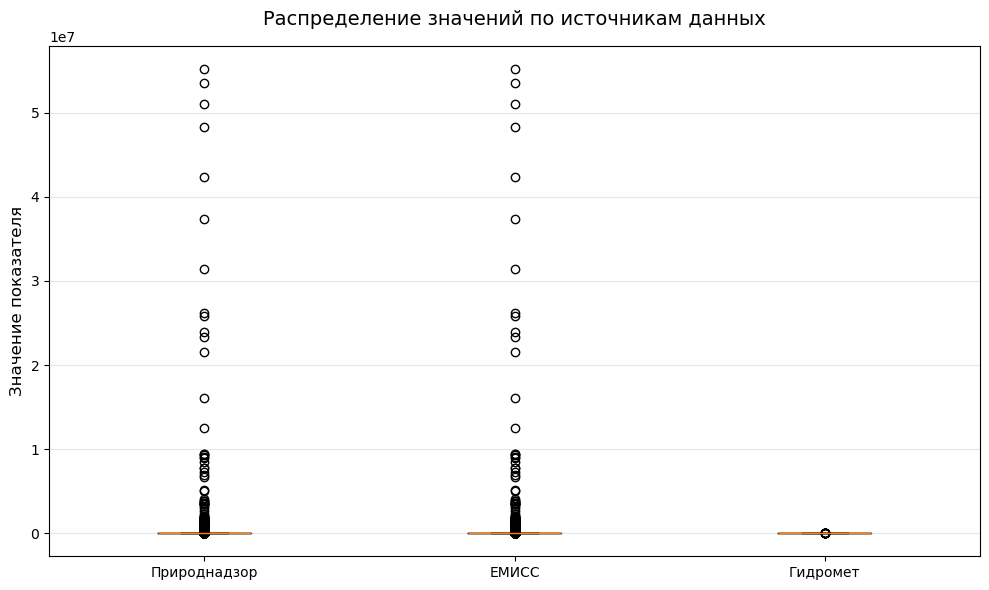

In [55]:
plt.figure(figsize=(10, 6))

source_data = []
source_labels = []

top_sources = df['source'].str.extract(r'(Росгидромет|Росприроднадзор|ЕМИСС)')[0].dropna().value_counts().head(3).index

for source in top_sources:
    mask = df['source'].str.contains(source, na=False)
    if mask.any():
        values = df[mask]['indicator_value'].dropna()
        if len(values) > 0:
            source_data.append(values.values)
            source_labels.append(source)

short_labels = {
    'Росгидромет': 'Гидромет',
    'Росприроднадзор': 'Природнадзор',
    'ЕМИСС': 'ЕМИСС'
}

plt.boxplot(source_data, labels=[short_labels.get(l, l) for l in source_labels])
plt.title('Распределение значений по источникам данных', fontsize=14, pad=15)
plt.ylabel('Значение показателя', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

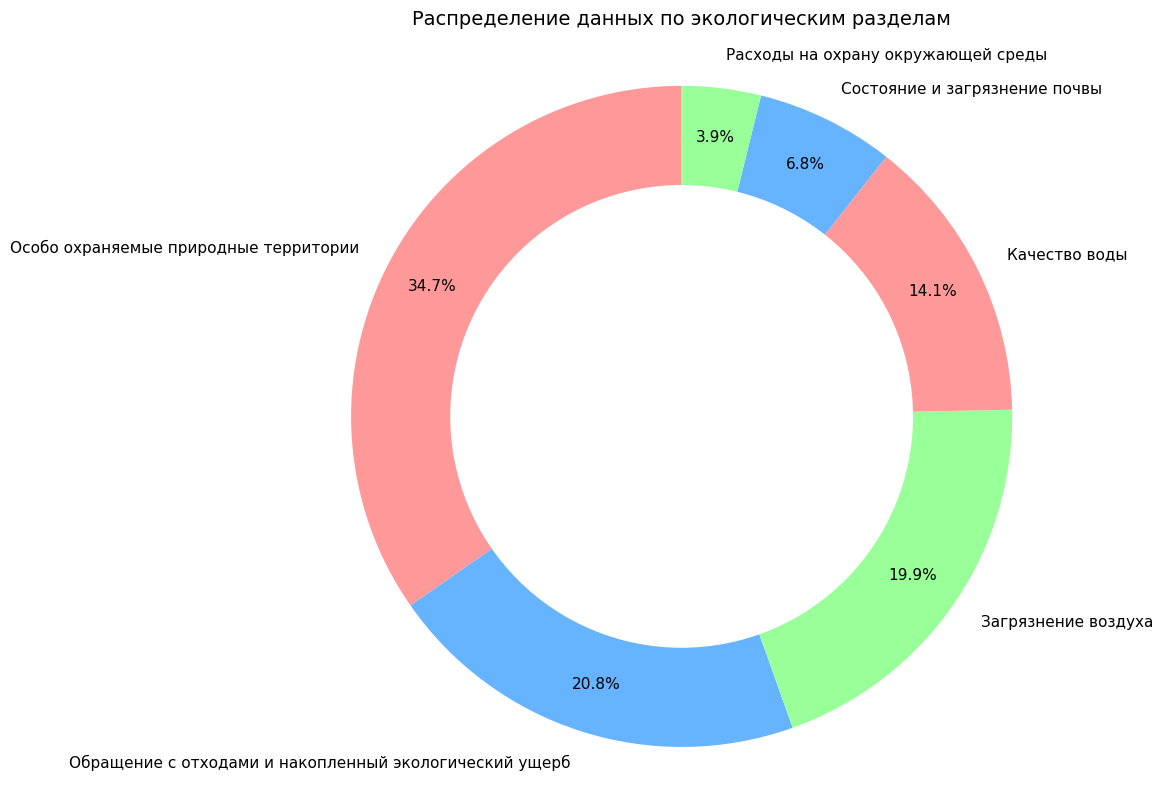

In [56]:
plt.figure(figsize=(10, 8))
section_counts = df['indicator_section'].value_counts()

section_names = {
    'Загрязнение атмосферы': 'Загрязнение воздуха',
    'Обеспеченность питьевой водой и загрязнение воды': 'Качество воды'
}

labels = [section_names.get(k, k) for k in section_counts.index]
sizes = section_counts.values
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.pie(sizes, labels=labels, colors=colors[:len(sizes)], autopct='%1.1f%%', 
        startangle=90, pctdistance=0.85, textprops={'fontsize': 11})

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Распределение данных по экологическим разделам', fontsize=14, pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

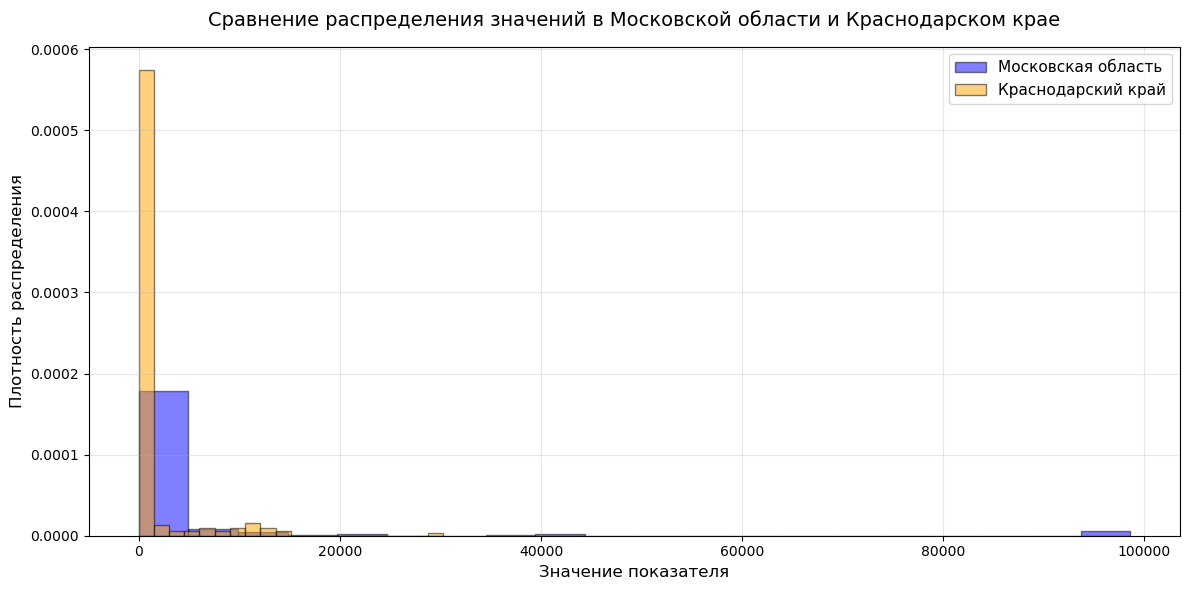

In [57]:
plt.figure(figsize=(12, 6))

regions_to_compare = ['Московская область', 'Краснодарский край']
colors = ['blue', 'orange']

for region, color in zip(regions_to_compare, colors):
    region_data = df[df['object_name'] == region]['indicator_value'].dropna()
    if len(region_data) > 0:
        plt.hist(region_data, bins=20, alpha=0.5, color=color, 
                 edgecolor='black', label=region, density=True)

plt.title('Сравнение распределения значений в Московской области и Краснодарском крае', 
          fontsize=14, pad=15)
plt.xlabel('Значение показателя', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [64]:
print("Статистики по типам объектов:")
group2 = df.groupby('object_level')['indicator_value'].agg(['mean', 'std', 'min', 'max'])
print(group2)

Статистики по типам объектов:
                      mean           std     min          max
object_level                                                 
регион        2.156619e+04  4.808676e+05 -57.300  26243706.35
страна        1.653259e+06  8.034132e+06   0.355  55225913.70


In [65]:
print("Сумма и количество по индикаторам:")
group3 = df.groupby('indicator_name')['indicator_value'].agg(['sum', 'count'])
print(group3.head(5))

Сумма и количество по индикаторам:
                                                              sum  count
indicator_name                                                          
Водные объекты, отнесенные к категориям «грязна...    6354.800000    255
Выбросы от передвижных источников (всего)           151405.933300    519
Выбросы от передвижных источников (на душу насе...   36511.802744    519
Выбросы от стационарных источников (всего)          258461.874742    519
Выбросы от стационарных источников (на душу нас...   80393.846629    519


In [66]:
print("Среднее и медиана по разделам:")
group1 = df.groupby('indicator_section')['indicator_value'].agg(['mean', 'median', 'count'])
print(group1)

Среднее и медиана по разделам:
                                                             mean  \
indicator_section                                                   
Загрязнение атмосферы                                  156.458072   
Обеспеченность питьевой водой и загрязнение воды       113.255688   
Обращение с отходами и накопленный экологически...  199837.377220   
Особо охраняемые природные территории                 1344.972671   
Расходы на охрану окружающей среды                   16271.266192   
Состояние и загрязнение почвы                           87.627181   

                                                         median  count  
indicator_section                                                       
Загрязнение атмосферы                                 40.491268   3539  
Обеспеченность питьевой водой и загрязнение воды      47.714394   2504  
Обращение с отходами и накопленный экологически...   252.368500   3698  
Особо охраняемые природные территории              

In [67]:
print("Сводная таблица (pivot_table):")
top_indicators = df['indicator_name'].value_counts().head(3).index.tolist()
df_subset = df[df['indicator_name'].isin(top_indicators)]

Сводная таблица (pivot_table):


In [68]:
print("Регионы с максимальными значениями по каждому индикатору:")
max_values = df.groupby('indicator_name').agg({
    'indicator_value': 'max',
    'object_name': 'first'
}).head(5)
print(max_values)

Регионы с максимальными значениями по каждому индикатору:
                                                    indicator_value  \
indicator_name                                                        
Водные объекты, отнесенные к категориям «грязна...       100.000000   
Выбросы от передвижных источников (всего)              15259.100000   
Выбросы от передвижных источников (на душу насе...       208.895767   
Выбросы от стационарных источников (всего)             17477.500000   
Выбросы от стационарных источников (на душу нас...      1997.418051   

                                                             object_name  
indicator_name                                                            
Водные объекты, отнесенные к категориям «грязна...        Алтайский край  
Выбросы от передвижных источников (всего)                 Алтайский край  
Выбросы от передвижных источников (на душу насе...  Российская Федерация  
Выбросы от стационарных источников (всего)                Алтайский к

In [69]:
for section in df['indicator_section'].unique():
    section_data = df[df['indicator_section'] == section]['indicator_value']
    if len(section_data) > 0:
        q25 = section_data.quantile(0.25)
        q75 = section_data.quantile(0.75)
        print(f"{section}: Q1={q25:.2f}, Q3={q75:.2f}, IQR={q75-q25:.2f}")

Загрязнение атмосферы: Q1=1.00, Q3=94.27, IQR=93.27
Обеспеченность питьевой водой и загрязнение воды: Q1=14.39, Q3=86.40, IQR=72.01
Расходы на охрану окружающей среды: Q1=1566.50, Q3=9522.75, IQR=7956.25
Особо охраняемые природные территории: Q1=2.00, Q3=185.00, IQR=183.00
Обращение с отходами и накопленный экологический ущерб: Q1=36.04, Q3=938.16, IQR=902.12
Состояние и загрязнение почвы: Q1=0.17, Q3=7.74, IQR=7.57


In [70]:
pivot = pd.pivot_table(df_subset, 
                       values='indicator_value',
                       index='object_name',
                       columns='indicator_name',
                       aggfunc='mean',
                       fill_value=0)
print("Размер сводной таблицы:", pivot.shape)
print("Первые 5 строк:")
print(pivot.head())

Размер сводной таблицы: (86, 3)
Первые 5 строк:
indicator_name                                Количество особо охраняемых природных территорий (региональных)  \
object_name                                                                                                     
Алтайский край                                                                       105.111111                 
Амурская область                                                                     144.777778                 
Архангельская область без автономного округа                                         100.111111                 
Астраханская область                                                                  50.666667                 
Белгородская область                                                                 301.888889                 

indicator_name                                Население в городах с высоким и очень высоким уровнем загрязнения воздуха, % городского населения  \
object_name  